In [1]:
import os

import numpy as np
import xarray as xr


import pandas as pd
import geopandas as gpd


import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt

import matplotlib.colors as colors
from shapely.geometry import Point

import itertools
import matplotlib.mlab as ml
import matplotlib.animation as animation

from open_data_utils import add_map, xr_to_gdf, add_country_names, country_intersections, select_extent

In [2]:
dir_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/"
#file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20090101-07/test2/grid_conc_20090101000000.nc"
#file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20180905/grid_conc_20180905000000.nc"
#file_path = "OD20180905/grid_conc_20180905000000.nc"
#file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20141009-13/hko_mult/grid_time_20141013000000.nc"
#file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20180126-20180201/grid_time_20180201210000.nc"
#file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20180126-20180201/long/grid_time_20180201210000.nc"
#file_path = "EI20091123-20091207/grid_time_20091207210000.nc"
#file_path = "EI20121123-20121207/grid_time_20121207210000.nc"
file_path = "EI20091123-20091207/wu_setup/grid_time_20091207210000.nc"
data = xr.open_dataset(dir_path + file_path)

In [3]:
data

<xarray.Dataset>
Dimensions:     (time: 165, longitude: 719, latitude: 360, height: 1,
                 numpoint: 72, numspec: 1, nageclass: 1, pointspec: 72)
Coordinates:
  * time        (time) datetime64[ns] 2009-12-07T20:00:00 ... 2009-12-01
  * longitude   (longitude) float32 -178.8 -178.2 -177.8 ... 179.2 179.8 180.2
  * latitude    (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * height      (height) float32 100.0
Dimensions without coordinates: numpoint, numspec, nageclass, pointspec
Data variables: (12/15)
    RELCOM      (numpoint) |S45 ...
    RELLNG1     (numpoint) float32 ...
    RELLNG2     (numpoint) float32 ...
    RELLAT1     (numpoint) float32 ...
    RELLAT2     (numpoint) float32 ...
    RELZZ1      (numpoint) float32 ...
    ...          ...
    RELEND      (numpoint) timedelta64[ns] ...
    RELPART     (numpoint) int32 ...
    RELXMASS    (numspec, numpoint) float32 ...
    LAGE        (nageclass) timedelta64[ns] ...
    ORO         (latitude, longitude) int32 ...
    spec001_mr  (nageclass, pointspec, time, height, latitude, longitude) float32 ...
Attributes: (12/37)
    Conventions:            CF-1.6
    title:                  FLEXPART model output
    institution:            NILU
    source:                 Version 10.4 (2019-11-12) model output
    history:                2022-02-17 17:08 +0100  created by b381737 on m11547
    references:             Stohl et al., Atmos. Chem. Phys., 2005, doi:10.51...
    ...                     ...
    ind_source:             1
    ind_receptor:           1
    mquasilag:              0
    nested_output:          0
    surf_only:              0
    linit_cond:             0

In [11]:
x = split_by_station(data)
x = x[0][dict(time=slice(0,5), longitude=slice(0,20), latitude=slice(0,20))]

In [15]:
x.to_netcdf("test.nc")

In [17]:
a = xr.open_dataarray("test.nc")

In [21]:
x.sum()

<xarray.DataArray 'spec001_mr' ()>
array(0., dtype=float32)

In [44]:
a = 2 if 1 == 2 else 1
a

1

In [150]:
class FlexDataset():
    def __init__(self, nc_path, extent=[-180, 180, -90, 90], datakey="spec001_mr"):
        self.DataSet = xr.open_dataset(nc_path)
        self.directory, self.file = nc_path.rsplit("/", 1)
        self.DataArrays = []
        self.extent = extent
        self.fig = None
        self.ax = None
        self.gl = None
        
        self.split_by_station(datakey)
    
    def init_figure(self, **kwargs):
        self.fig, self.ax = plt.subplots(1, 1, **kwargs)
        

    def plot(self, arr_ind, t_ind, release_ind, **kwargs):
        load_flag = False
        xarr = self.DataArrays[arr_ind]
        
        if t_ind == "all": 
            t_ind = list(np.arange(len(arr.time)))
            path = os.path.join(self.directiory, f"sum_arr_ind{arr_ind}.nc")
            if os.path.exists(path):
                xarr = xr.open_dataarray(path)
                xarr = select_extent(xarr)
                print(f"Loaded data from {path}")
                load_flag = True
        
        if not load_flag:
            if isinstance(t_ind, int): t_ind = [t_ind]
            if release_ind == "all": release_ind = list(np.arange(len(arr.time)))
            if isinstance(release_ind, int): release_ind = [release_ind]

            xarr = xarr[dict(time=t_ind, pointspec=release_ind)]
            xarr = xarr.sum(dim=["time", "pointspec"])
        xarr = xarr.where(xarr != 0)
        xarr.plot(ax=self.ax, **kwargs)
        
    def select_extent(self, xarr):
        """Select extent of xarray.DataArray with geological data

        Args:
            xarr (xarray.DataArray): ...returns
            lon1 (float): left
            lon2 (float): right
            lat1 (float): lower
            lat2 (float): upper

        Returns:
            xarray.DataArray: cut xarray
        """    
        lon1, lon2, lat1, lat2 = self.extent
        xarr = xarr.where((xarr.longitude >= lon1) & (xarr.longitude <= lon2), drop=True)
        xarr = xarr.where((xarr.latitude >= lat1) & (xarr.latitude <= lat2), drop=True)
        return xarr
    
    def add_map(feature_list = [cf.COASTLINE, cf.BORDERS, [cf.STATES, dict(alpha=0.1)]],
                **grid_kwargs,
               ):
        """Add map to axes using cartopy.

        Args:
            ax (Axes): Axes to add map to
            feature_list (list, optional): Features of cartopy to be added. Defaults to [cf.COASTLINE, cf.BORDERS, [cf.STATES, dict(alpha=0.1)]].
            extent (list, optional): list to define region ([lon1, lon2, lat1, lat2]). Defaults to None.

        Returns:
            Axes: Axes with added map
            Gridliner: cartopy.mpl.gridliner.Gridliner for further settings
        """    
        self.ax.set_extent(self.extent, crs=ccrs.PlateCarree()) if extent is not None else None
        for feature in feature_list:
            feature, kwargs = feature if isinstance(feature, list) else [feature, dict()]
            ax.add_feature(feature, **kwargs)
        grid = True
        gl = None
        try:
            grid = grid_kwargs["grid"]
            grid_kwargs.pop("grid", None)
        except KeyError:
            pass
        if grid:
            grid_kwargs =  dict(draw_labels=True, dms=True, x_inline=False, y_inline=False) if not bool(grid_kwargs) else grid_kwargs
            self.gl = ax.gridlines(**grid_kwargs)
            self.gl.top_labels = False
            self.gl.right_labels = False
    
    def split_by_station(self, datakey):
        values = np.unique(self.DataSet.RELLNG1.values)
        index_sets = []
        for val in values:
            index_sets.append(np.concatenate(np.argwhere(self.DataSet.RELLNG1.values == val)))
        DataArray = self.DataSet[datakey]
        for ind in index_sets:
            self.DataArrays.append(DataArray.isel(dict(pointspec = ind)))
            
    def load_DataArrays(self):
        files = os.listdir(self.directory)
        path = os.path.join(self.directiory, f"sum_arr_ind0.nc")
        if os.path.exists(path):
            max_ind = 0  
            for f in files:
                if "all_arr_ind" in f:
                    print(f"Found {f}")
                    ind = int(f.rsplit("ind", 1)[-1])
                    max_ind = ind if ind > max_ind else max_ind
            for i in range(max_ind+1):
                DataArray.append(xr.load_dataarray(os.path.join(self.directory, f"sum_arr_ind{i}.nc")))
        else:
            raise FileNotFoundError
            
    def save_DataArrays(self, include_sums=True):
        arr_path = os.path.join(self.directory, "all_arr_ind")
        sum_path = os.path.join(self.directory, "sum_arr_ind")
        for i, xarr in enumerate(self.DataArrays):
            xarr.to_netcdf(f"{arr_path}{i}.nc")
            if include_sums:
                xarr_sum = xarr.sum(dim=["time", "pointspec"])
                xarr_sum.to_netcdf(f"{sum_path}{i}.nc")
        print(f"Saved data to {arr_path}*")
        if include_sums: print(f"Saved data to {sum_path}*")

In [151]:
fd = FlexDataset(dir_path + file_path)

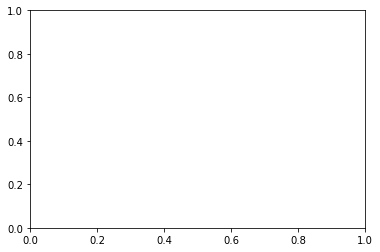

In [152]:
fd.init_figure()


In [156]:
fd.plot(arr_ind=0, t_ind=100, release_ind=4, cmap="jet")

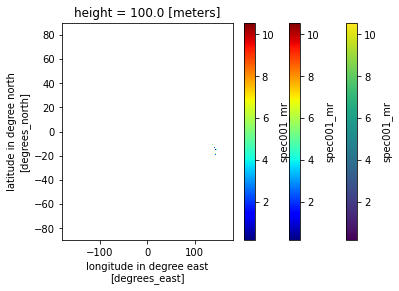

In [157]:
fd.fig

In [7]:
def split_by_station(dataset, datakey="spec001_mr"):
    values = np.unique(dataset.RELLNG1.values)
    index_sets = []
    for val in values:
        index_sets.append(np.concatenate(np.argwhere(dataset.RELLNG1.values == val)))
    dataarray = dataset[datakey]
    dataarrays = []
    for ind in index_sets:
        dataarrays.append(dataarray.isel(dict(pointspec = ind)))
    return dataarrays

'spec001_mr'

[<xarray.DataArray 'spec001_mr' (nageclass: 1, pointspec: 36, time: 165,
                                 height: 1, latitude: 360, longitude: 719)>
 [1537509600 values with dtype=float32]
 Coordinates:
   * time       (time) datetime64[ns] 2009-12-07T20:00:00 ... 2009-12-01
   * longitude  (longitude) float32 -178.8 -178.2 -177.8 ... 179.2 179.8 180.2
   * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
   * height     (height) float32 100.0
 Dimensions without coordinates: nageclass, pointspec
 Attributes:
     units:        s
     long_name:    CO2
     decay:        -0.0006932163
     weightmolar:  44.0
     ohcconst:     -9.99
     ohdconst:     -9.9e-09
     vsetaver:     0.0,
 <xarray.DataArray 'spec001_mr' (nageclass: 1, pointspec: 36, time: 165,
                                 height: 1, latitude: 360, longitude: 719)>
 [1537509600 values with dtype=float32]
 Coordinates:
   * time       (time) datetime64[ns] 2009-12-07T20:00:00 ... 2009-12-01
   * lo

# One Frame

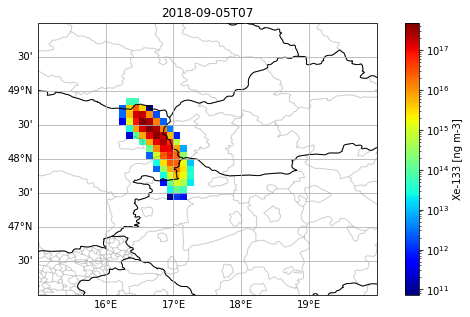

In [8]:
t_ind = 6
h_ind = 0
pointspec = 0
#data selection
mass = data.spec001_mr.isel(time=[t_ind], height=[h_ind], pointspec=[pointspec])
#mass = mass[dict(latitude=slice(30,50), longitude=slice(5,25))]
mass = mass.where(mass!=0)

extent = [15,20,46,50]
norm = colors.LogNorm() 

fig, ax= plt.subplots(1, 1, figsize=(10,5), subplot_kw=dict(projection=ccrs.PlateCarree()))

mass.plot(ax=ax, cmap="jet", norm=norm, transform=ccrs.PlateCarree())

ax.set_title(data.time.values[t_ind].astype('datetime64[h]'))

add_map(ax, extent=extent)

#ax.scatter(16.3738,48.2082,s=200, label="Vienna", color="yellow", edgecolor="black", marker="*")
#ax.scatter(16.1469, 49.0845, s=100, label="Power plant", color="red", marker="^")

#fig.savefig(f"/mnt/lustre01/pf/b/b381737/python_scripts/figures/hko_T{t_ind}.png")
plt.show()

# Full footprint

Text(0.5, 1.0, 'Footprint of Darwin station 2012')

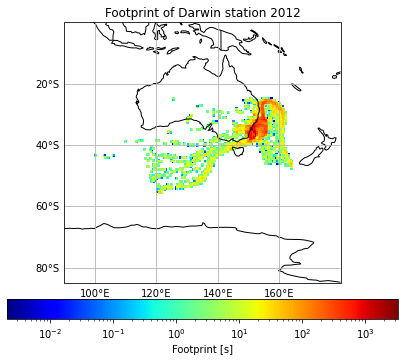

In [6]:
pointspec=[3,4,5]
if type(pointspec) != list:
    sum_dict = dict(dim=["time"])
else:
    sum_dict = dict(dim=["time", "pointspec"])

cmap = "jet"
extent = [90,180,-85,0]
norm = colors.LogNorm() 

fig, ax = plt.subplots(1, 1, figsize=(7,6), subplot_kw=dict(projection=ccrs.PlateCarree()))
add_map(ax, extent=extent)

mass = data.spec001_mr[dict(pointspec=pointspec)].sum(**sum_dict)
mass = mass.where(mass!=0)
vmin = np.min(mass).values
vmax = np.max(mass).values

mass.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(),
          
         cbar_kwargs=dict(label="Footprint [s]",
                         orientation="horizontal",
                         pad=0.05))
ax.set_title("Footprint of Darwin station 2012")
#fig.savefig(f"/mnt/lustre01/pf/b/b381737/python_scripts/figures/australia/dar_full_12.png")

# Differences between footprints

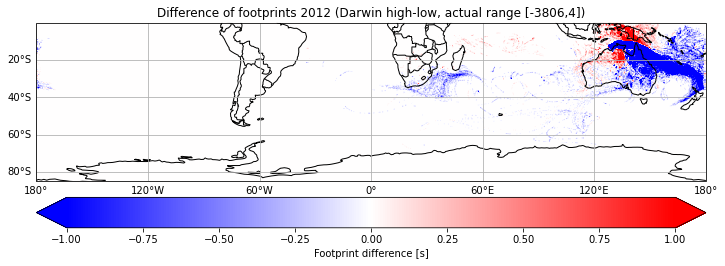

In [30]:
pointspec1 = [3]
pointspec2 = [5]

if type(pointspec1)!=list and type(pointspec2) != list:
    sum_dict = dict(dim=["time"])
else:
    sum_dict = dict(dim=["time", "pointspec"])
mass1 = data.spec001_mr[dict(pointspec=pointspec1)].sum(**sum_dict)
mass2 = data.spec001_mr[dict(pointspec=pointspec2)].sum(**sum_dict)
#diff = data.spec001_mr[dict(pointspec=[pointspec1, pointspec2])].sum(dim="time").diff(dim="pointspec")
#.sum(**sum_dict)
diff = mass2 - mass1

cmap = "bwr"#["jet"]#

extent = [-180,180,-85,0]
vmin = -1
vmax = 1
min_val = np.min(diff.values)
max_val = np.max(diff.values)

fig, ax = plt.subplots(1, 1, figsize=(12,6), subplot_kw=dict(projection=ccrs.PlateCarree()))
add_map(ax, extent=extent)

#mass = data.spec001_mr[dict(pointspec=pointspec)].sum(dim="time")
#mass = mass.where(mass!=0)


diff.plot(ax=ax, cmap=cmap, transform=ccrs.PlateCarree(),
          vmin=vmin, vmax=vmax,
          cbar_kwargs=dict(label="Footprint difference [s]",
                         orientation="horizontal",
                         pad=0.05))
ax.set_title(f"Difference of footprints 2012 (Darwin high-low, actual range [{min_val:.{0}f},{max_val:.{0}f}])")
#fig.savefig(f"/mnt/lustre01/pf/b/b381737/python_scripts/master/open_data/figures/australia/dar_high_vs_low_12.png")

# Assign Country to data and choose

In [34]:
mass = data.spec001_mr[dict(pointspec=[0,1,2])].sum(dim=["time", "pointspec"])[0]
gdf = xr_to_gdf(mass, "spec001_mr")
gdf = add_country_names(gdf)
#gdf.to_pickle("/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20121123-20121207/gdf.pkl")
ci = country_inersections(gdf, "Australia")
#intersections = country_inersections(mass, "Australia")

In [35]:
gdf.to_pickle("/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20121123-20121207/gdf_woll_12.pkl")

In [95]:
columns=["Station","Year","Total [s]", "Australia [%]", "Other countries [%]", "Ocean [%]"]
df = pd.DataFrame(columns=columns)
direc="/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20121123-20121207/"
l = []
for y in ["09", "12"]:
    for stat in ["woll", "dar"]:
    
        l.append("Wollongong" if stat == "woll" else "Darwin")
        l.append("20"+y)
        path = f"gdf_{stat}_{y}.pkl"
        print(path)
        gdf = pd.read_pickle(direc+path)
        ret = country_intersections(gdf, "Australia")
        tot = gdf.spec001_mr.sum()
        l.append(round(tot, 0))
        for key in ret.keys():
            if key == "rest":
                continue
            l.append(round(ret[key].spec001_mr.sum()/tot*100, 2))
        df = df.append(dict(zip(columns,l)), ignore_index=True)
        l = []

gdf_woll_09.pkl
gdf_dar_09.pkl
gdf_woll_12.pkl
gdf_dar_12.pkl


# Animation

In [ ]:
#for vmin
mass = data.spec001_mr.where(data.spec001_mr!=0)
#height index, vmin, vmax for cbar
h_ind = 0
vmin = np.min(mass.isel(pointspec=[0])).values
vmax = np.max(mass.isel(pointspec=[0])).values
print(vmin)
print(vmax)

#box to be shown TODO: prevent error if not standard projection
extent=[0,180,-85,-0]

cmap = "jet"
norm = colors.LogNorm()

fig, ax = plt.subplots(1, 1, figsize=(10,5), subplot_kw=dict(projection=ccrs.PlateCarree()))

#total number of frames
frames=len(data.time.values)
#milliseconds between frames
interval=100

def index_mod(index):
    return index

def add_to_ax(ax):
    ax.scatter(114.1742, 22.3025,s=200, label="hko", color="yellow", edgecolor="black", marker="*")
    #ax.scatter(16.1469, 49.0845, s=100, label="Power plant", color="red", marker="^")
    return ax

def animate(index):
    ind = index_mod(index)
    ax.clear()
    mass = data.spec001_mr.isel(time=[ind], height=[h_ind], pointspec=[0])
    mass = mass.where(mass!=0)
    if len(fig.axes)==1:
        mass.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, 
                  norm=norm, 
                  transform=ccrs.PlateCarree(), 
                  cbar_kwargs=dict(label="Footprint [s]"))
    else:
        mass.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, 
                  norm=norm, 
                  transform=ccrs.PlateCarree(),
                  add_colorbar=False)
    ax.set_title(data.time.values[ind].astype('datetime64[h]'))
    add_map(ax, extent=extent)
    add_to_ax(ax)

ani = animation.FuncAnimation(fig, animate, frames, interval=interval, blit=False)
ani.save("/mnt/lustre01/pf/b/b381737/python_scripts/master/open_data/animations/australia/wu.gif")

# Compare two datasets

1914299000.0
3.5516213e+18


/home/b/b381737/.conda/envs/plot_env/lib/python3.10/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


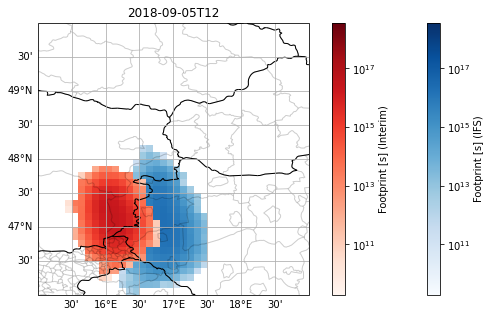

In [26]:
#for vmin
file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/OD20180905/grid_conc_20180905000000.nc"
data1 = xr.open_dataset(file_path)
mass1 = data1.spec001_mr
file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20180905/grid_conc_20180905000000.nc"
data2 = xr.open_dataset(file_path)
mass2 = data2.spec001_mr
mass2 = select_extent(mass2, 5, 25, 40, 55)

mass1 = mass1.where(mass1!=0)
mass2 = mass2.where(mass2!=0)



#height index, vmin, vmax for cbar
h_ind = 0
vmin = min([np.min(mass1.isel(pointspec=[0])).values, np.min(mass2.isel(pointspec=[0])).values])
vmax = max([np.max(mass1.isel(pointspec=[0])).values, np.max(mass2.isel(pointspec=[0])).values])
print(vmin)
print(vmax)

#box to be shown TODO: prevent error if not standard projection
extent=[15, 19, 46, 50]

cmaps = ["Blues", "Reds"]
labels = ["Footprint [s] (IFS)", "Footprint [s] (Interim)"]#["Footprint [s] (Interim)", "Footprint [s] (IFS)"]
norm = colors.LogNorm()

fig, ax = plt.subplots(1, 1, figsize=(10,5), subplot_kw=dict(projection=ccrs.PlateCarree()))

#total number of frames
frames=len(data1.time.values)
#milliseconds between frames
interval=100

def index_mod(index):
    return index

def add_to_ax(ax):
    #ax.scatter(114.1742, 22.3025,s=200, label="hko", color="yellow", edgecolor="black", marker="*")
    #ax.scatter(16.1469, 49.0845, s=100, label="Power plant", color="red", marker="^")
    return ax

def animate(index):
    ind = index_mod(index)
    ax.clear()
    for i, mass in enumerate([mass1,mass2]):
        mass = mass.isel(dict(time=ind, height=0))
        mass = mass.where(mass!=0)
        if len(fig.axes)==(i+1):
            mass.plot(ax=ax, cmap=cmaps[i], vmin=vmin, vmax=vmax, 
                      norm=norm, 
                      transform=ccrs.PlateCarree(), 
                      cbar_kwargs=dict(label=labels[i]))
        else:
            mass.plot(ax=ax, cmap=cmaps[i], vmin=vmin, vmax=vmax, 
                      norm=norm, 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False)
    ax.set_title(data1.time.values[ind].astype('datetime64[h]'))
    add_map(ax, extent=extent)
    add_to_ax(ax)

ani = animation.FuncAnimation(fig, animate, frames, interval=interval, blit=False)
ani.save("/mnt/lustre01/pf/b/b381737/python_scripts/master/open_data/animations/tutorial/vienna_comparision2.gif")